## 18 - 3D
>Map with depth. Add a third dimension to your map. Whether it’s visualizing elevation, buildings, or something more abstract, today’s about thinking beyond flat surfaces. 🎢🏔️

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from osgeo import gdal
import warnings

In [2]:
def fix_wonky(arr: np.array,
              coords: bool=False):
    '''
    for trimming 2d arrays that have some nans around their border.
    such as when a DEM from epsg4326 is reprojected to utm and the data
    edges are at an angle
    
    this identifies the first and last columns/rows in arr that
    aren't all nan and slices arr inside of these cols/rows (inclusive)
    
    if the input array contains some nans in all columns (or rows)
    this won't fail, it'll just return the input array
    '''
    just_a_few_nans = np.logical_or(np.count_nonzero(np.isnan(arr).sum(axis=1))==1,
                                    np.count_nonzero(np.isnan(arr).sum(axis=0))==1)

    if just_a_few_nans:
        warnings.warn('nothing to worry about - returning original')
        return arr
    
    # name, array to operate on, column index, step to increase index by to move along one
    # for top and bottom use the transpose of the input,
    # this means the [:, idx] does not need to be flipped to [idx, :]
    left = ('left', arr, 0, 1)
    right = ('right', arr, -1, -1)
    top = ('top', arr.T, 0, 1)
    bottom = ('bottom', arr.T, -1, -1)
    
    edge_dict = {}
    for edge in [left, right, top, bottom]:
        edge_name, array, idx, step = edge
        nonzero = np.nonzero(~np.isnan(array[:,idx]))
        # if it's all nans try the next row/column along
        while len(nonzero[0]) == 0:
            idx += step
            nonzero = np.nonzero(~np.isnan(array[:,idx]))
        # once found append index to output dictionary
        edge_dict[edge_name] =nonzero[0][0]
    
    # in case of not doing anything
    if edge_dict['left'] != edge_dict['right']:
        rows = slice(*sorted([edge_dict['left'], edge_dict['right']]))
    else:
        warnings.warn('cannot trim any rows')
        rows = slice(0, arr.data.shape[0])
        
    if edge_dict['top'] != edge_dict['bottom']:
        cols = slice(*sorted([edge_dict['top'], edge_dict['bottom']]))
    else:
        warnings.warn('cannot trim any cols')
        cols = slice(0, arr.data.shape[1])
    
    # option to reutrn clipped coordinates
    if coords:
        x, y = coords
        return arr[rows, cols], x[rows], y[cols]
    else:
        return arr[rows, cols]
    
def make_ridge_line_collection(arr, nlines=50, angle=45):
    '''
    make & return LineCollection() comprised of `nlines`
    across DEM `arr` as viewed from perspective angle of `angle`
    '''
    # make normalized x,y grid (0-1)
    # that contains as many rows as nlines
    # and as many columns as input array
    height, width = arr.shape
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, nlines)

    X, Y = np.meshgrid(x, np.linspace(0, 1, nlines))

    # sample z, at indices
    xidx = np.clip(np.int32(width * X), 0, width-1)
    yidx = np.clip(np.int32(height * Y), 0, height-1)

    #scale to between 0-1
    scaled = (arr - arr.min()) / (arr.max() - arr.min())
    
    # for "projecting"
    z_coef = np.cos(np.radians(angle))
    y_coef = np.sin(np.radians(angle))

    prj_surf = (
        z_coef * scaled -
        y_coef * np.expand_dims(np.linspace(0., 1., arr.shape[0]), axis=1)
    )

    # for masking points that are 'behind' high points
    prj_surf_max = np.flipud(np.maximum.accumulate(np.flipud(prj_surf)))
    mask = prj_surf_max == prj_surf
    prj_surf[~mask] = np.nan
    prj_surf[~mask] = prj_surf_max[~mask]
    
    # make the line collection
    lc = LineCollection(
        [
            list(zip(x, prj_surf[yidx[line], xidx[line]])) for line in range(nlines)
        ]
        )
    return lc


In [3]:
gdal.UseExceptions()
tif = gdal.Open('tmp.tif')
data = tif.ReadAsArray()
geotransform = tif.GetGeoTransform()
minx = geotransform[0]
maxy = geotransform[3]
maxx = minx + geotransform[1] * tif.RasterXSize
miny = maxy + geotransform[5] * tif.RasterYSize
bounds = (minx, miny, maxx, maxy)

xcoords = np.linspace(minx, maxx, tif.RasterXSize, endpoint=True)
ycoords = np.linspace(miny, maxy, tif.RasterYSize, endpoint=True)

data, xcoords, ycoords = fix_wonky(data, coords=(xcoords, ycoords))
bounds = [min(xcoords), min(ycoords), max(xcoords), max(ycoords)]

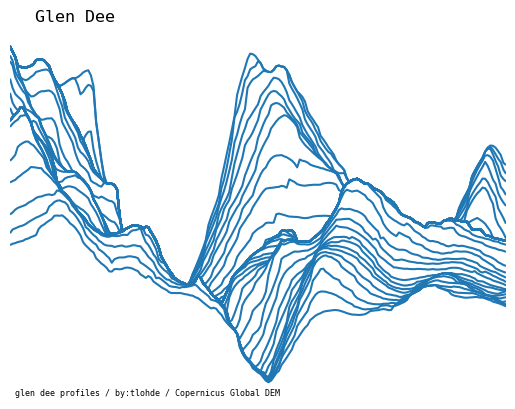

In [4]:
nlines = 50
num_frames = 180
angle_steps = np.concatenate([np.linspace(0, 90, int(num_frames/2)),
                              np.linspace(90, 0, int(num_frames/2))])

with plt.rc_context({'animation.embed_limit':500,
                     'animation.html': 'jshtml',
                     'figure.dpi': 100,
                     'font.family': 'monospace'}):
    
    fig, ax = plt.subplots()
    line = LineCollection([])
    ax.add_collection(line)
    ax.set_axis_off()
    ax.set_title('Glen Dee', x=0.05, ha='left')
    ax.annotate('glen dee profiles / by:tlohde / Copernicus Global DEM',
                xy=(0.01, 0.01),
                xycoords='axes fraction',
                fontsize=6)
    
    def init():
        line.set_segments([])
        return line,

    def update(frame):
        new_angle = angle_steps[frame]
        tmp_lc = make_ridge_line_collection(data, nlines=nlines, angle=new_angle)
        segments = tmp_lc.get_segments()
        seg_arr = np.vstack(segments)
        minx, miny = seg_arr.min(axis=0)
        maxx, maxy = seg_arr.max(axis=0)
        ybuff = (maxy-miny) * 0.05    
        line.set_paths(tmp_lc.get_segments())
        ax.set(xlim=(minx, maxx),
               ylim=(miny-ybuff, maxy+ybuff))

    anim = animation.FuncAnimation(fig=fig,
                                   func=update,
                                   init_func=init,
                                   frames=num_frames,
                                   interval=30)
    
    anim.save('day18.gif')